## Data Analysis

The preprocessing notebook was used to create a dataset, collecting power and traffic data while surfing on major website with and without an ad-blocker.

In this notebook, we do a statistical analysis of this dataset using graphs to interprete and compare the impact of using ad-blockers.


### Importing libraries

In [1]:
import pandas as pd # For data manipulation
import numpy as np # For data manipulation
import requests # For HTTP Requests to the API
import seaborn as sns # For charts
from IPython.display import display # To dataframe displaying
import scipy.stats as stats # For stats
import pingouin as pg # For stats
from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import datetime, timezone
import warnings


# Suppress all warnings
warnings.filterwarnings("ignore")

#Set display options to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Auto-detect the width
pd.set_option('display.max_colwidth', None)  # Show full content of each column

### Defining Constants

- Define a DataFrame to Map conditions (i.e. use of adblock) and Functional Units (Surfing to a given website) to Corresponding Tests and Actions to Monitor:

    We use a DataFrame to map each (adblock condition, functional unit) combination to the test containing the samples and the action to monitor within those tests.

    EXAMPLE:
    - Considering the 'surf to google' functional unit with adblock enabled, we look up the entry `['enabled', 'google']`. This entry directs us to the test name `'topnews_adblock'` and specifies the name of the action to monitor: `'surf_to_https://google.com'`.

    - Considering the 'surf to yahoo' functional unit with adblock disabled, we look up the entry `['disabled', 'yahoo']`. This entry directs us to the test name `'topnews_noadblock'` and specifies the name of the action to monitor: `'surf_to_https://yahoo.com'`.


In [2]:
ADBLOCK_CONDITION = ['enabled', 'disabled']
FUNCTIONAL_UNITS =     [
                        'google',
                        'yahoo',  
                        'bing',
                        'wikipedia',
                        'weather',
                        'cnn',
                        'foxnews',
                        'nytimes',
                        'sohu',
                        'taobao']

def get_test_name_and_action(adblock, functional_unit):
    test_name = "topnews_"
    action = None
    test_name += 'adblock' if adblock == 'enabled' else 'noadblock'

    if functional_unit == 'session':
        action = 'session'
    elif functional_unit == 'google':
        action = 'surf_to_' + 'https://google.com'
    elif functional_unit == 'yahoo':
        action = 'surf_to_' + 'https://yahoo.com'
    elif functional_unit == 'bing':
        action = 'surf_to_' + 'https://bing.com'
    elif functional_unit == 'wikipedia':
        action = 'surf_to_' + 'https://wikipedia.org'
    elif functional_unit == 'weather':
        action = 'surf_to_' + 'https://weather.com'
    elif functional_unit == 'cnn':
        action = 'surf_to_' + 'https://cnn.com'
    elif functional_unit == 'foxnews':
        action = 'surf_to_' + 'https://foxnews.com'
    elif functional_unit == 'nytimes':
        action = 'surf_to_' + 'https://nytimes.com'
    elif functional_unit == 'sohu':
        action = 'surf_to_' + 'https://sohu.com'
    elif functional_unit == 'taobao':
        action = 'surf_to_' + 'https://taobao.com'


    return test_name, action
    

# Generate all combinations of provider, adblock, pgp, and functional_unit
tests_and_actions = [
    [adblock, functional_unit] + list(get_test_name_and_action(adblock, functional_unit))
    for adblock in ADBLOCK_CONDITION
    for functional_unit in FUNCTIONAL_UNITS
]

# Create the DataFrame
TESTS_AND_ACTIONS = (pd.DataFrame(tests_and_actions, columns=['ADBLOCK_CONDITION', 'FUNCTIONAL_UNIT', 'TEST', 'ACTION']) \
    .set_index(['ADBLOCK_CONDITION', 'FUNCTIONAL_UNIT']))


TESTS_AND_ACTIONS

TEST  \
ADBLOCK_CONDITION FUNCTIONAL_UNIT                      
enabled           google             topnews_adblock   
                  yahoo              topnews_adblock   
                  bing               topnews_adblock   
                  wikipedia          topnews_adblock   
                  weather            topnews_adblock   
                  cnn                topnews_adblock   
                  foxnews            topnews_adblock   
                  nytimes            topnews_adblock   
                  sohu               topnews_adblock   
                  taobao             topnews_adblock   
disabled          google           topnews_noadblock   
                  yahoo            topnews_noadblock   
                  bing             topnews_noadblock   
                  wikipedia        topnews_noadblock   
                  weather          topnews_noadblock   
                  cnn              topnews_noadblock   
                  foxnews          topnews_noadblock   
                  nytimes          topnews_noadblock   
                  sohu             topnews_noadblock   
                  taobao           topnews_noadblock   

                                                          ACTION  
ADBLOCK_CONDITION FUNCTIONAL_UNIT                                 
enabled           google              surf_to_https://google.com  
                  yahoo                surf_to_https://yahoo.com  
                  bing                  surf_to_https://bing.com  
                  wikipedia        surf_to_https://wikipedia.org  
                  weather            surf_to_https://weather.com  
                  cnn                    surf_to_https://cnn.com  
                  foxnews            surf_to_https://foxnews.com  
                  nytimes            surf_to_https://nytimes.com  
                  sohu                  surf_to_https://sohu.com  
                  taobao              surf_to_https://taobao.com  
disabled          google              surf_to_https://google.com  
                  yahoo                surf_to_https://yahoo.com  
                  bing                  surf_to_https://bing.com  
                  wikipedia        surf_to_https://wikipedia.org  
                  weather            surf_to_https://weather.com  
                  cnn                    surf_to_https://cnn.com  
                  foxnews            surf_to_https://foxnews.com  
                  nytimes            surf_to_https://nytimes.com  
                  sohu                  surf_to_https://sohu.com  
                  taobao              surf_to_https://taobao.com

- Defining the metrics and their units

In [3]:
METRICS = [
    'CPU_ENERGY',                   # cpu_energy_rapl_msr_component
    'MEMORY_ENERGY',                # memory_energy_rapl_msr_component
    'NETWORK_IO',                   # network_io_cgroup_container
    'ESTIMATED_MACHINE_ENERGY',     # psu_energy_ac_xgboost_machine
    'DURATION']

COMPUTED_METRICS = ['CPU_POWER',
                    'MEMORY_POWER',
                    'ESTIMATED_MACHINE_POWER']
TOTALS = [  'USE_PHASE_MACHINE_EMISSION',
            'EMBODIED_MACHINE_EMISSION',
            'USE_PHASE_NETWORK_EMISSION',
            'EMBODIED_NETWORK_EMISSION',
            'TOTAL'
        ]

UNITS = {
    'CPU_ENERGY': 'mJ',
    'MEMORY_ENERGY': 'mJ',
    'NETWORK_IO' : 'Byte',
    'ESTIMATED_MACHINE_ENERGY' : 'mJ',
    'DURATION' : 'µs',
    'CPU_POWER' : 'W',
    'MEMORY_POWER' : 'W',
    'ESTIMATED_MACHINE_POWER' : 'W',
    'NETWORK_IO_RATE' : 'MB/s',
    'USE_PHASE_MACHINE_EMISSION' : 'gCO2e',
    'EMBODIED_MACHINE_EMISSION' : 'gCO2e',
    'USE_PHASE_NETWORK_EMISSION' : 'gCO2e',
    'EMBODIED_NETWORK_EMISSION' : 'gCO2e',
    'TOTAL' : 'gCO2e'
}

- **`count_distinct_samples`**: We define a function to count the samples for each scenario i.e., (provider, adblock condition, pgp condition, functional_unit) combination


In [4]:
def count_distinct_samples(metadata: pd.DataFrame):
    """
    Count the number of valid samples for each (functional_unit, adblock_condition) combination.
    A valid sample is defined as a unique pair of start and end timestamps for each (TEST, ACTION).

    Args:
        metadata (pd.DataFrame): The metadata DataFrame to count samples from.

    Returns:
        pd.DataFrame: A DataFrame containing the sample counts and missing sample counts.
    """
    return (metadata.groupby(['ADBLOCK_CONDITION', 'FUNCTIONAL_UNIT'])
                .agg(SAMPLE_COUNT=('START_TS', 'count'), 
                    MISSING_SAMPLES=('START_TS', lambda x: max(0, 100 - x.count())))  # Count missing samples
            )

- Load the dataset

In [5]:
data = pd.read_csv('2025_topnews_data.csv')
data.head()

,TEST,RUN_ID,ADBLOCK_CONDITION,FUNCTIONAL_UNIT,START_TS,DURATION,MEMORY_ENERGY,CPU_ENERGY,ESTIMATED_MACHINE_ENERGY,NETWORK_IO
0,topnews_noadblock,01b119ae-3493-4ad7-9615-5cadc607c134,disabled,bing,1740558071453834,5697165,6880,29771,121210,1389978
1,topnews_noadblock,0210e477-ce47-442b-9244-f86300c4b0e3,disabled,bing,1740561023117631,5662340,6693,28083,118734,1412414
2,topnews_noadblock,0228b223-e668-4387-a3da-d44505b88e75,disabled,bing,1740549085084757,5640072,6500,27463,116859,1426121
3,topnews_noadblock,066ed16d-f1ee-4e85-a8f5-db52eb4e62be,disabled,bing,1740538496526166,5628367,6620,29046,117138,1377055
4,topnews_noadblock,086e4fca-cc65-4383-82c3-a5cb64b65caa,disabled,bing,1740560610817217,5556337,6601,28042,116580,1395070


- Remove outliers with IQR :

    The Interquartile Range (IQR) method is used to remove outliers because some measurements are disturbed by background processes affecting data transfer and power consumption. We ensure that we are left with at least 100 valid samples for each group.

In [6]:

def remove_outliers(data, columns, group_columns=['ADBLOCK_CONDITION', 'FUNCTIONAL_UNIT']):
    """
    Removes outliers from the dataframe using the IQR method per group (FUNCTIONAL_UNIT, ADBLOCK_CONDITION).
    """
    # Iterate over each metric (column)
    for col in columns:
        # Define a function to remove outliers for each group
        def remove_outliers_for_group(group_df):
            Q1 = group_df[col].quantile(0.25)
            Q3 = group_df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            return group_df[(group_df[col] >= lower_bound) & (group_df[col] <= upper_bound)]
        
        # Apply the function to remove outliers for each group
        data = data.groupby(group_columns).apply(remove_outliers_for_group).reset_index(drop=True)
    
    return data

# Columns to remove outliers for
columns_to_check = ['DURATION', 'MEMORY_ENERGY', 'CPU_ENERGY', 'ESTIMATED_MACHINE_ENERGY', 'NETWORK_IO']

# Remove outliers
clean_data = remove_outliers(data, columns=columns_to_check)

# Display the numbers of valid samples left
count_distinct_samples(clean_data)



SAMPLE_COUNT  MISSING_SAMPLES
ADBLOCK_CONDITION FUNCTIONAL_UNIT                               
disabled          bing                      146                0
                  cnn                       143                0
                  foxnews                   118                0
                  google                    110                0
                  nytimes                    99                1
                  sohu                      117                0
                  taobao                    113                0
                  weather                   110                0
                  wikipedia                 109                0
                  yahoo                     144                0
enabled           bing                      159                0
                  cnn                       158                0
                  foxnews                   147                0
                  google                     78               22
                  nytimes                   163                0
                  sohu                      117                0
                  taobao                    118                0
                  weather                   131                0
                  wikipedia                 136                0
                  yahoo                     158                0

- Compute the mean power data and change the units

In [7]:
def change_scale(data):
    for metric, unit in UNITS.items():
        if metric in data.columns:
            if unit == 'mJ':
                data[metric] = data[metric]/1e3
                UNITS[metric] = 'J'
            if unit == 'Byte':
                data[metric] = data[metric]/1e6
                UNITS[metric] = 'MB'
            if unit == 'µs':
                data[metric] = data[metric]/1e6
                UNITS[metric] = 's'
                
def get_power_data(data:pd.DataFrame):
    new_columns = ['CPU_POWER', 'MEMORY_POWER', 'ESTIMATED_MACHINE_POWER']
    columns = ['CPU_ENERGY', 'MEMORY_ENERGY', 'ESTIMATED_MACHINE_ENERGY']
    for i in range(len(new_columns)):
        data[new_columns[i]] = (data[columns[i]]/data['DURATION'])

In [8]:
change_scale(clean_data)
get_power_data(clean_data)

- Define a function to get the means and standard deviation of each test

In [9]:
def compute_means_and_stds(data:pd.DataFrame):

    return data.groupby(['ADBLOCK_CONDITION', 'FUNCTIONAL_UNIT']) \
                .agg({  'DURATION': ['mean', 'std'],
                        'MEMORY_ENERGY': ['mean', 'std'],
                        'CPU_ENERGY': ['mean', 'std'],
                        'ESTIMATED_MACHINE_ENERGY': ['mean', 'std'],
                        'NETWORK_IO': ['mean', 'std'],
                        'MEMORY_POWER': ['mean', 'std'],
                        'CPU_POWER': ['mean', 'std'],
                        'ESTIMATED_MACHINE_POWER': ['mean', 'std'],
                    })


- Define a function to plot the means and standard deviations

In [10]:
def plot_metrics_bars(means_and_stds: pd.DataFrame, metric: str):

    # Create a new figure
    fig, ax = plt.subplots(figsize=(10, 6))

    # Get unique functional units and calculate positions
    functional_units = FUNCTIONAL_UNITS
    num_conditions = len(means_and_stds) // len(functional_units)  # Number of provider-condition combinations per functional unit
    bar_width = 0.8 / num_conditions  # Space bars based on the number of provider-condition combinations
    index = np.arange(len(functional_units))  # Set x-axis positions for the functional units

    # Iterate over each functional unit to plot the bars
    for j, functional_unit in enumerate(functional_units):
        # Extract rows for the current functional unit
        rows = means_and_stds.xs(functional_unit, level='FUNCTIONAL_UNIT')

        # Iterate over the provider/condition combinations for the functional unit
        for i, (idx, row) in enumerate(rows.iterrows()):
            adblock = idx
            mean_value, std_value = row[metric]['mean'], row[metric]['std']

            #Get the appropriate color for the given provider and condition
            if adblock == 'enabled':
                adblock_label = 'adblock'
                color = 'lightblue'
            else:
                adblock_label = 'noadblock'
                color = 'gray'

            # Calculate bar position based on functional unit and provider-condition index
            bar_position = index[j] + i * bar_width

            # Label the first bar of each functional unit with provider/condition info
            label = f'{adblock_label}' if j == 0 else None

            # Plot the bar and add error bars
            ax.bar(bar_position, mean_value, bar_width, edgecolor='k', label=label, color = color)
            ax.errorbar(bar_position, mean_value, yerr=std_value, fmt='o', color='black', capsize=5)
    
    # Set the labels, title, and ticks
    ax.set_xlabel('Functional Units')
    ax.set_ylabel(f'{metric} ({UNITS.get(metric, "")})')
    ax.set_title(f'Mean and Standard Dev of {metric} ({UNITS.get(metric,"")}) by Functional Unit')
    ax.set_xticks(index + bar_width * (num_conditions - 1) / 2)
    ax.set_xticklabels(functional_units)

    # Add the legend
    ax.legend()

    # Adjust layout and display
    plt.tight_layout()
    plt.show()


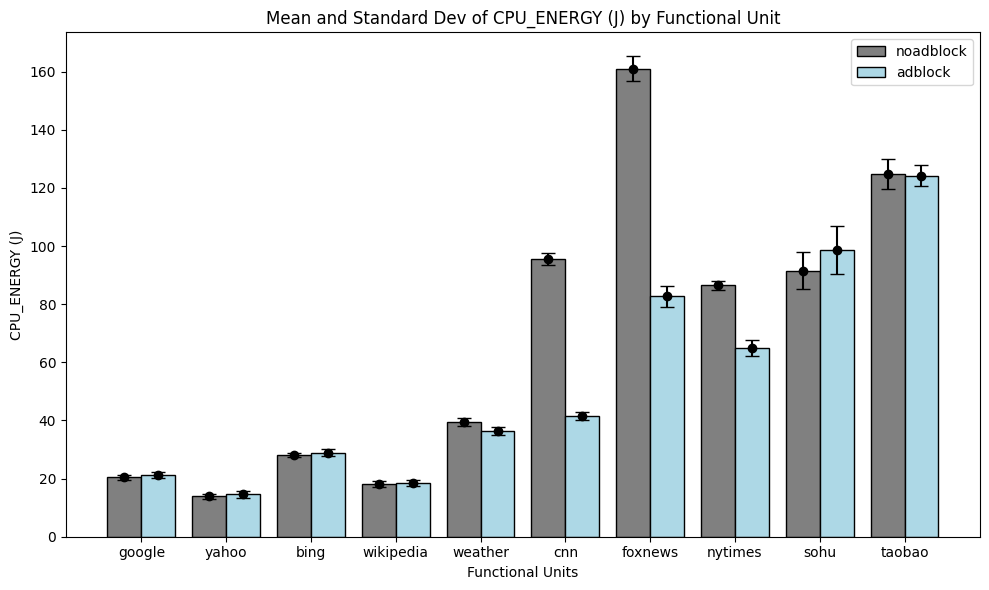

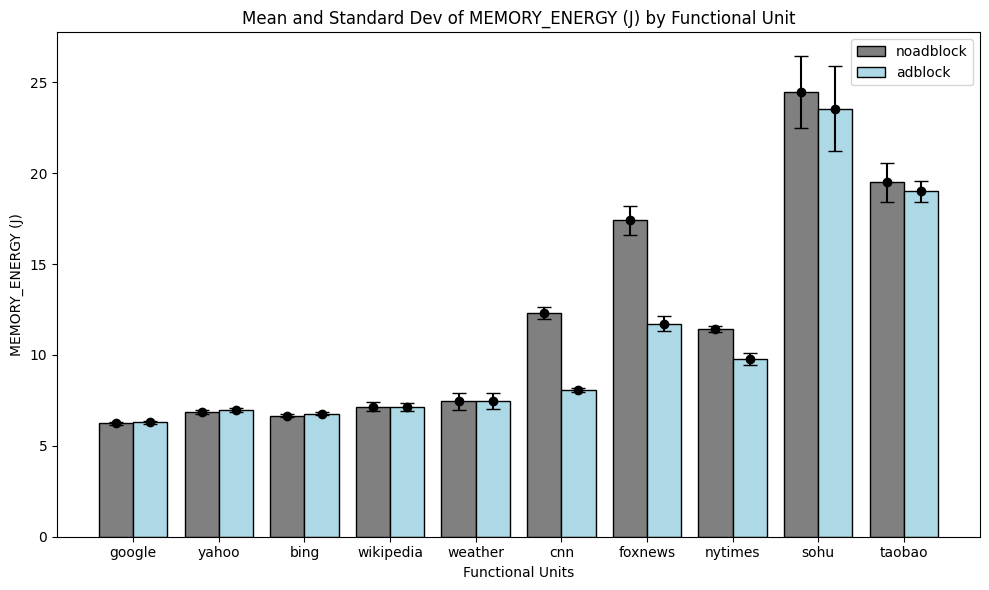

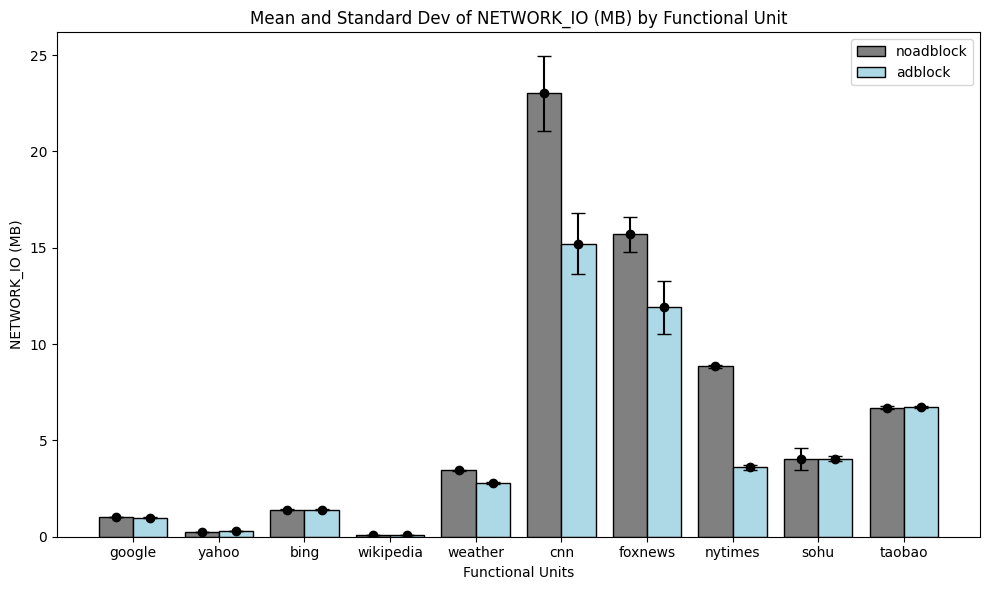

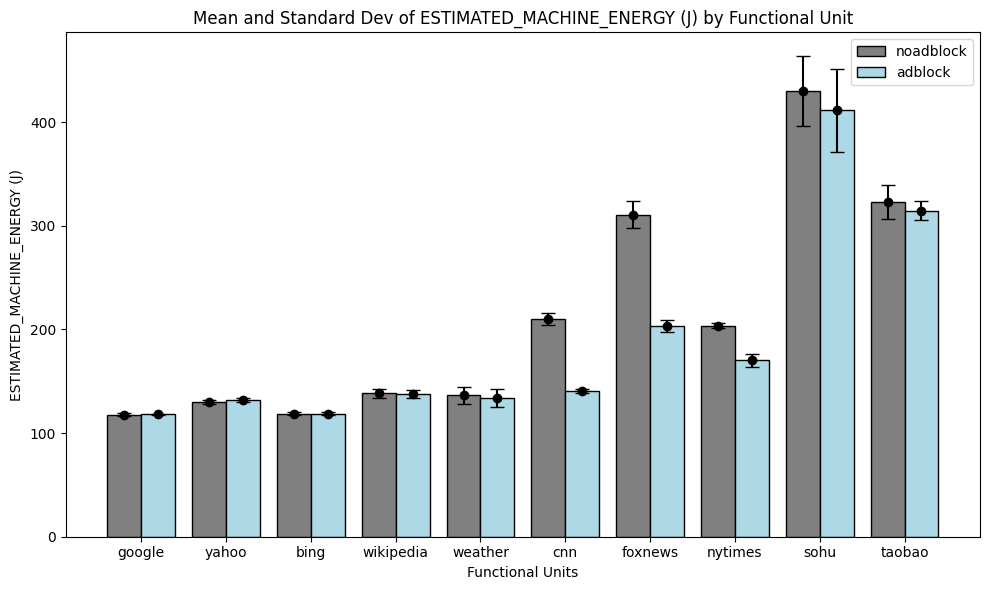

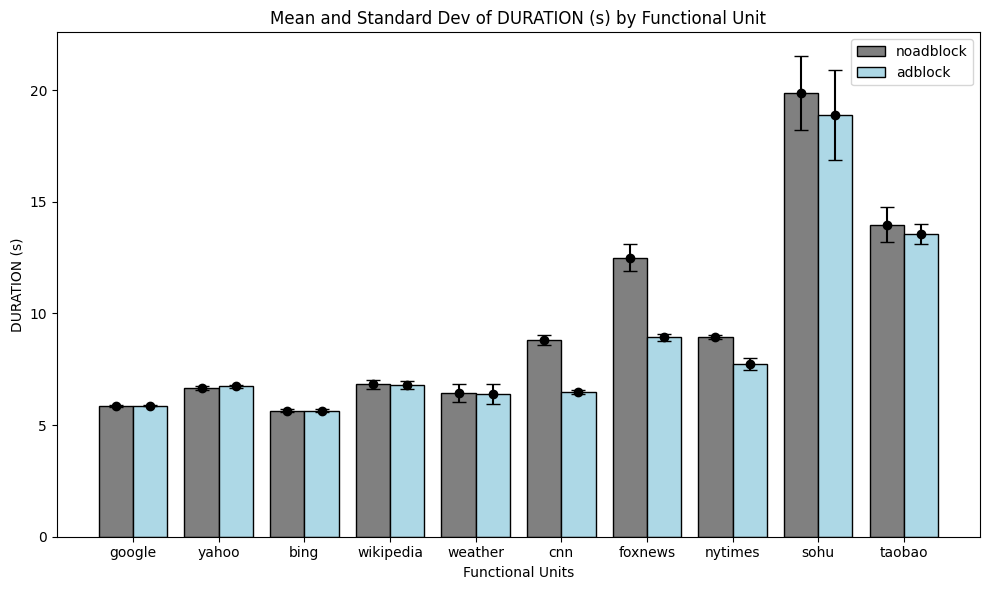

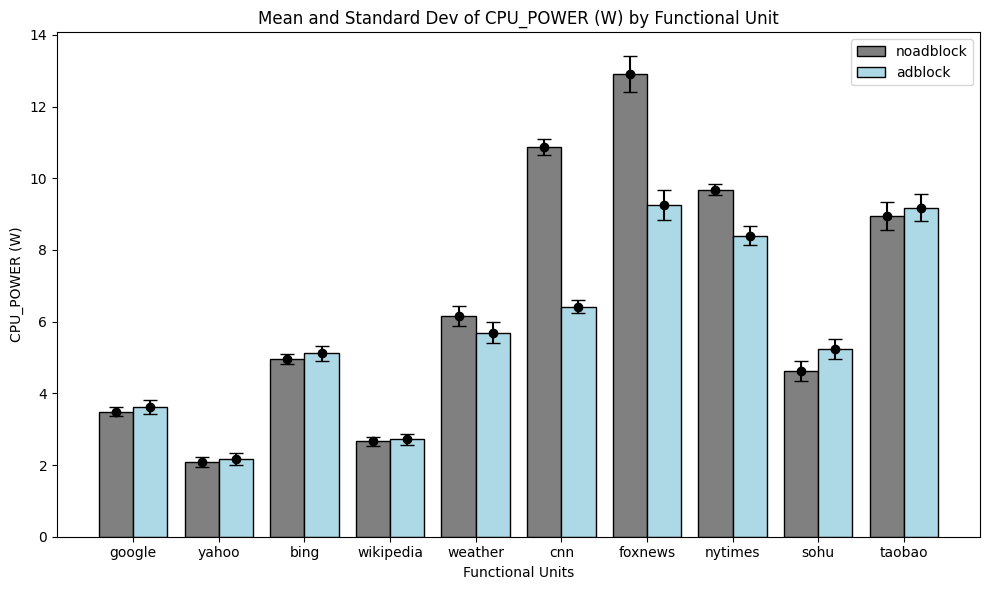

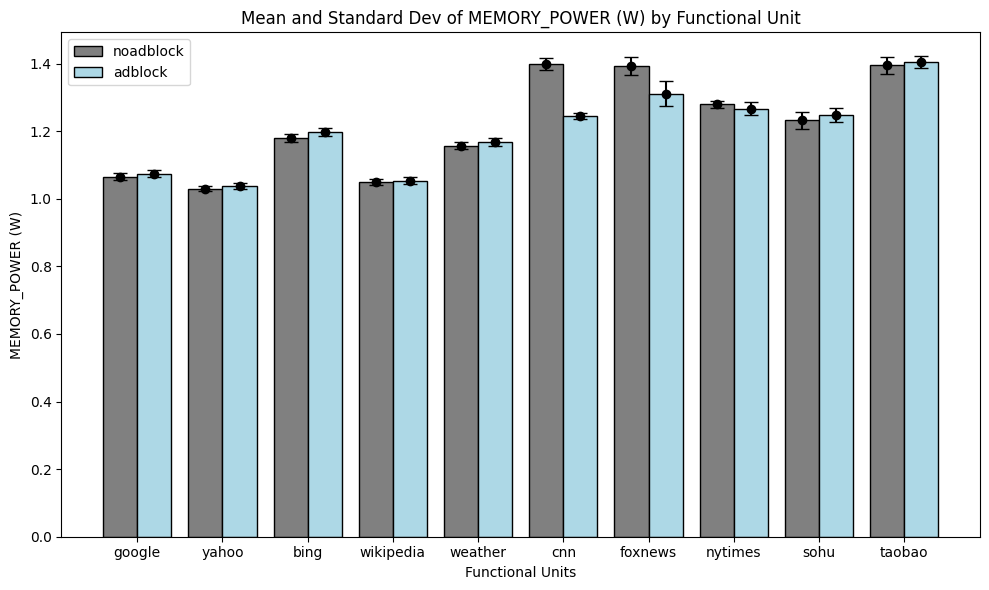

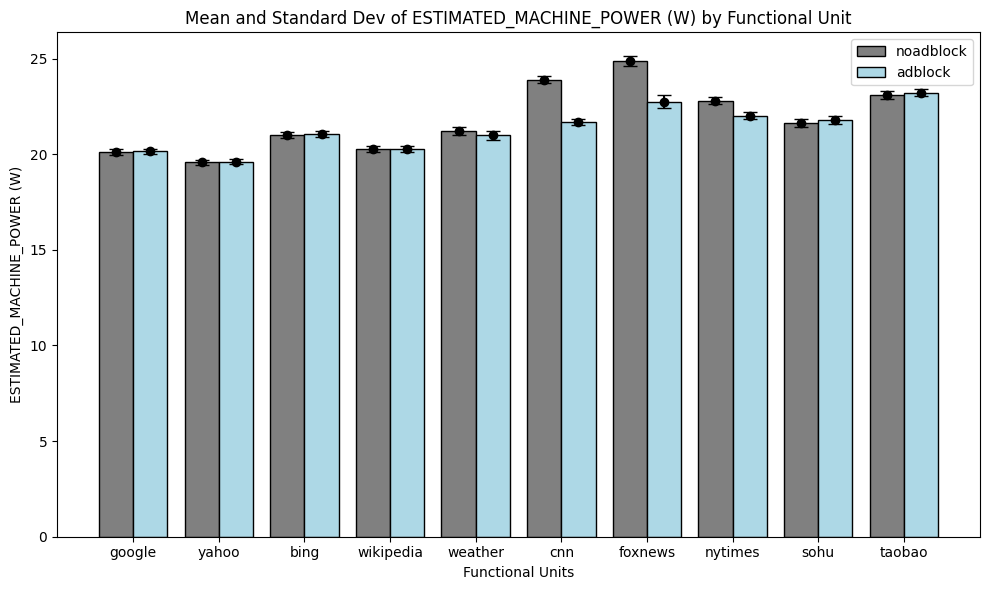

In [11]:
means_and_stds = compute_means_and_stds(clean_data)

for metric in METRICS + COMPUTED_METRICS:
    plot_metrics_bars(means_and_stds, metric)

### Statistically Significant Difference Testing

**Comparing Adblock vs. No-Adblock:**

The function `compute_gains` compares 2 groups of samples.  It is used to assess the effect of an ad-blocker a given website. It uses an adequate paired t-test to determine if the differences in metrics between these conditions are statistically significant. Pairs of test are considered dependent since they're performed on the same website.
**Args:**
- `data (pd.DataFrame)`: Contains metrics for each provider and action.
- `comparison_pair (dict)`: Contains the conditions to compare.
- `independence (bool)`: Indicates if the groups are independent or dependent.
- `metrics (list)`: List of metrics to compare.

**Returns:**
- `pd.DataFrame`: Results include gains and percentage gains for each action and provider.

**Plotting Results:**

The function `plot_gains` is used to visualise the gains or percentage gains or CO2 eq gains for each comparison. It highlights significant differences in metrics between the conditions.

**Args:**
- `gains (pd.DataFrame)`: DataFrame containing the gain results.
- `title (str)`: Title of the plot.
- `percentage (bool)`: Indicates if the gains are in percentage.
- `CO2 (bool)`: Indicates if the gains are in CO2 emissions.
- `label (str)`: Label for the plot.
- `figsize (tuple)`: Size of the plot.

**Returns:**
- `None`: Displays the plot.

In [ ]:
def get_samples(data, functional_unit, adblock='disabled'
                ,
                columns=METRICS+COMPUTED_METRICS):
    return data[(data['ADBLOCK_CONDITION'] == adblock) &
                (data['FUNCTIONAL_UNIT'] == functional_unit)][columns]

def verify_assumptions_and_perform_test(group_A, group_B, independence):
    """
    Verifies assumptions (normality, homogeneity of variance) and automatically performs 
    the appropriate parametric or non-parametric test using pingouin.

    Args:
    - group_A: Data for the first group.
    - group_B: Data for the second group.
    - independence: Boolean flag to indicate if the groups are independent (True) or dependent (False).

    Returns:
    - test_stat: Test statistic from the statistical test.
    - p_value: p-value from the statistical test.
    """
    
    # Automatically use pingouin to perform the correct t-test or non-parametric test
    if independence:
        result = pg.ttest(group_A, group_B, paired=False, correction="auto")
    else:
        result = pg.ttest(group_A, group_B, paired=True, correction="auto")
    
    # Extract p-value from the result
    p_value = result['p-val'].values[0]
    
    return p_value

def compute_gains(data, comparison_pair, independence, metrics = METRICS+COMPUTED_METRICS):
    """
    Loop over the comparisons and compute statistical test results, 
    applying assumption verification and appropriate statistical tests.
    """

    results = pd.DataFrame(index=metrics, columns=FUNCTIONAL_UNITS)
    percentage_results = pd.DataFrame(index=metrics, columns=FUNCTIONAL_UNITS)

    for functional_unit in FUNCTIONAL_UNITS:
        # Get the data samples for the current comparison
        test_A = get_samples(data, functional_unit, **comparison_pair['A'], columns=metrics)
        test_B = get_samples(data, functional_unit, **comparison_pair['B'], columns=metrics)

        # Ensure both groups have at least one sample
        if len(test_A) > 0 and len(test_B) > 0:

            # If the sizes differ, trim to the size of the smaller group
            min_size = min(len(test_A), len(test_B))
            test_A = test_A.iloc[:min_size]
            test_B = test_B.iloc[:min_size]

            # Perform the statistical test for each metric
            for metric in metrics:

                # Run the assumption check and statistical test
                p_value = verify_assumptions_and_perform_test(test_A[metric], test_B[metric], independence)

                # If the p-value is less than 0.05, compute the gain
                if p_value < 0.05:
                    
                    gain = test_A[metric].mean() - test_B[metric].mean()
                    percentage_gain = 100*(test_A[metric].mean() - test_B[metric].mean())/test_B[metric].mean()

                    results.loc[metric, functional_unit] = gain
                    percentage_results.loc[metric, functional_unit] = percentage_gain
                else:
                    results.loc[metric, functional_unit] = np.nan
                    percentage_results.loc[metric, functional_unit] = np.nan

    return results, percentage_results

def plot_gains(gains: pd.DataFrame, percentage: pd.DataFrame = None, title: str = None, CO2=False, figsize=(10, 3), fontsize=9):
    """
    Plots a comparison table showing both absolute gains and their percentage changes, or CO2e gains.
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('tight')
    ax.axis('off')


    def scale_value_unit(value, unit):
        """
        Scales the value and adjusts the unit based on magnitude.
        Base Units are : J, s, W, MB, MB/s
        """

        # Adjust CO2 units
        if CO2:
            if abs(value) > 1e9:
                value /= 1e9
                unit = 'ktCO2e'
            elif abs(value) > 1e6:
                value /= 1e6
                unit = 'tCO2e'
            elif abs(value) > 1e3:
                value /= 1e3
                unit = 'KgCO2e'
            elif abs(value) > 1:
                value /= value
                unit = 'gCO2e'
            elif abs(value) > 1e-3:
                value *= 1e3
                unit = 'mgCO2e'
            elif abs(value) > 1e-6:
                value *= 1e6
                unit = 'µgCO2e'
            return value, unit

        si_prefixes = [
            (1e9, 'G'),
            (1e6, 'M'),
            (1e3, 'k'),
            (1, ''),
            (1e-3, 'm'),
            (1e-6, 'µ')
        ]
        # Handle specific units
        if unit in ['MB', 'MB/s']:
            value *= 1e6  # Convert MB to Byte for scaling
            base_unit = unit[1:]  # B, B/s
        else:
            base_unit = unit  # J, s, W


        for factor, prefix in si_prefixes:
            if abs(value) >= factor:
                scaled_value = value / factor
                return scaled_value, f"{prefix}{base_unit}"
        return value, unit  # fallback if no scaling applies


    def format_cell_value(value, percentage_value, unit):
        if np.isnan(value):
            return '-'

        value, unit = scale_value_unit(value, unit)
        
        sign = "+" if value > 0 else "-"
        text = f"{sign}{abs(value):.0f} {unit}"
        if percentage_value is not None:
            text += f" ({abs(percentage_value):.0f}%)"
        return text

    # Create combined formatted cell values and corresponding color map
    formatted_cells = []
    colourmap = []

    for i, metric in enumerate(gains.index):
        formatted_row = []
        color_row = []
        for j, column in enumerate(gains.columns):
            value = gains.iloc[i, j]
            percent = percentage.iloc[i, j] if percentage is not None else None

            formatted_row.append(format_cell_value(value, percent, UNITS.get(metric, '')))

            if column in ['mean', 'std']:
                color_row.append('lightblue')

            elif isinstance(value, (int, float)) and not np.isnan(value):
                if metric == 'TOTAL':
                    if value < 0:
                        color_row.append('#199F19')
                    elif value > 0:
                        color_row.append('#CC8500')
                    else:
                        color_row.append('#adadad')
                else:
                    if value < 0:
                        color_row.append('#90EE90')
                    elif value > 0:
                        color_row.append('#FFB833')
                    else:
                        color_row.append('#FFFFFF')
                
            else:
                if metric == 'TOTAL':
                    color_row.append('#adadad')
                else:
                    color_row.append('white')

        formatted_cells.append(formatted_row)
        colourmap.append(color_row)

    table = ax.table(cellText=formatted_cells,
                     rowLabels=gains.index,
                     colLabels=gains.columns,
                     cellLoc='center',
                     loc='center',
                     cellColours=colourmap,
                     rowColours=['#949393' if index == "TOTAL" else '#ffffff' for index in gains.index]  # Darker gray for "TOTAL", light gray for others
    )

    # Get the row number corresponding to "TOTAL"
    total_row_index = gains.index.get_loc('TOTAL') + 1 if 'TOTAL' in gains.index else None

    for (row, col), cell in table.get_celld().items():
        # Align all text to the right
        cell.get_text().set_ha('right')

        # Bold column headers (row 0)
        if row == 0:
            cell.get_text().set_weight('bold')

        # Bold entire "TOTAL" row (including row label at col = -1)
        if total_row_index is not None and row == total_row_index:
            cell.get_text().set_weight('bold')

    plt.subplots_adjust(left=0, right=1)

    table.auto_set_font_size(False)
    table.set_fontsize(fontsize)
    table.auto_set_column_width
    table.scale(1.5, 1.6)
    if title is not None:
        plt.title(title)
    plt.show()

Effect of using Adblock


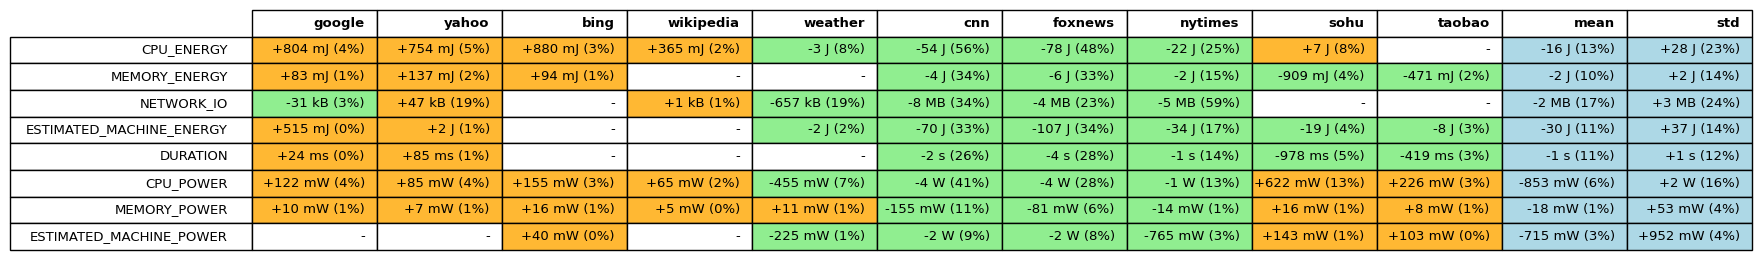

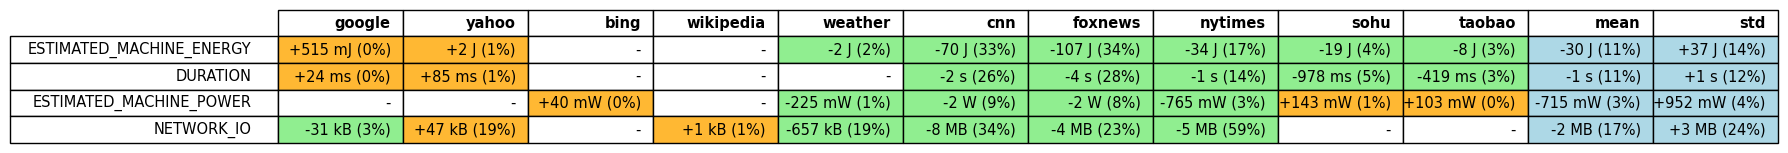

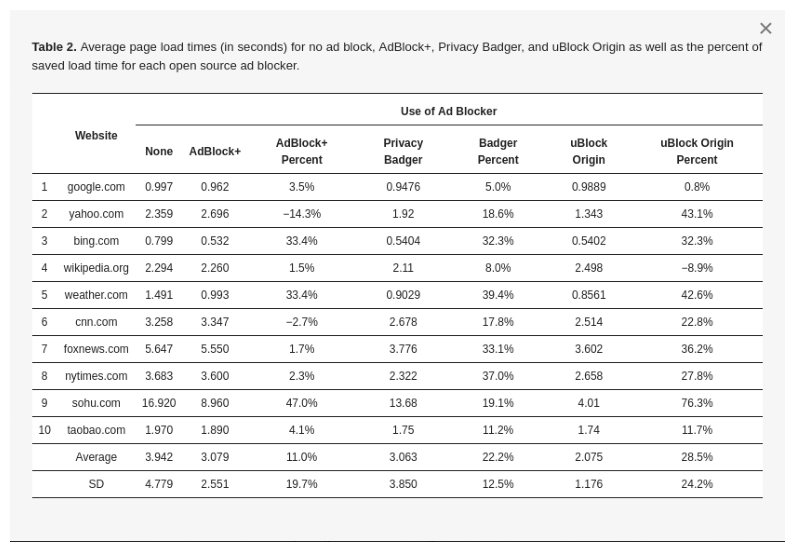

In [40]:
comparisons = {
    "Effect of using Adblock": {
        'A': {'adblock': 'enabled'},
        'B': {'adblock': 'disabled'}
    }
}
for title, comparison_pair in comparisons.items():
    gains, percentage_gains = compute_gains(clean_data, comparison_pair, independence=False)

    # Add mean and std columns to gains and percentage_gains DataFrames
    gains['mean'] = gains.mean(axis=1)
    gains['std'] = gains.std(axis=1)

    percentage_gains['mean'] = percentage_gains.mean(axis=1)
    percentage_gains['std'] = percentage_gains.std(axis=1)
    
    print(title)
    plot_gains(gains=gains, percentage=percentage_gains, fontsize=9.5)

    index_to_keep = [ 'ESTIMATED_MACHINE_ENERGY', 'DURATION', 'ESTIMATED_MACHINE_POWER', 'NETWORK_IO']

    plot_gains(gains=gains.loc[index_to_keep], percentage=percentage_gains.loc[index_to_keep], fontsize=10.5, figsize=(10, 1))


img = mpimg.imread('study_stat.png')

# Create a plot
fig, ax = plt.subplots(figsize= (10,10))
ax.imshow(img)
ax.axis('off')
plt.show()


### Here we convert the mean measurment into GHG emissions
> Embodied Emission Calculation Formula

To calculate the embodied emissions on the user side, we use the formula:

**M = TE × (TR / EL) × RS**

Where:
- **M**: Embodied emissions
- **TE**: Total embodied emissions, meaning the sum of LCA emissions for all hardware components
- **TR**: Time reserved, meaning the length of time the hardware is reserved for use by the software - here this is the computed duration of the functional unit
- **EL**: Expected lifetime of the resources
- **RS**: Resources share - Here it's equal to 1 since we dedicate the whole machine to the functional unit (i.e. no hardware virtualisation)

Reference: [Green Software Foundation - SCI Guide](https://sci-guide.greensoftware.foundation/M/)

To calculate the network side embodied emissions, we use the overall ratio of embodied to use phase emissions and apply it to the network emissions:

`embodied_network_emissions = network_emissions * embodied_to_use_phase_ratio`

Effect of using Adblock (CO2e)


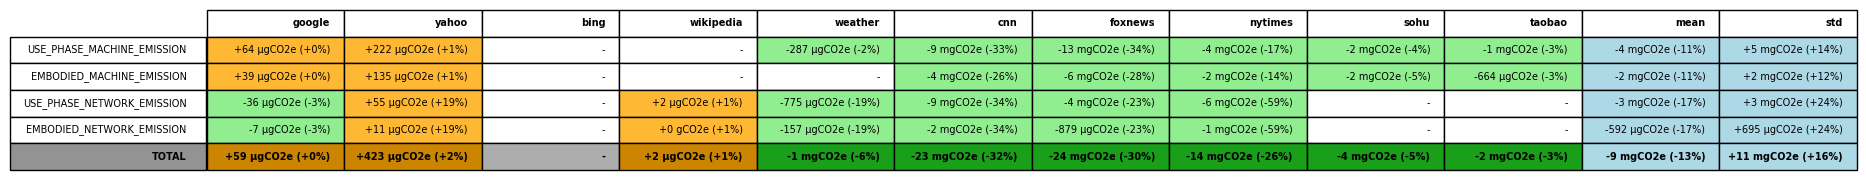

In [ ]:
#################################################
############# Use-Phase Parameters ##############
#################################################
 
 
electricity_carbon_intensity = 445 # [gCO2 / kWh] World 2024 - see https://www.iea.org/reports/electricity-2025/emissions
kwh_per_J = 2.7778e-7 # 2.777e-7 [kWh/J]

energy_intensity_of_data_transfered = 0.002652 * 1e-3 # 0.002652 [kWh / GB] * 1e-3 [GB / MB] --> [kWh / MB] see https://www.green-coding.io/co2-formulas/
network_emissions = energy_intensity_of_data_transfered * electricity_carbon_intensity # [gCO2 / MB]


#################################################
############# Embodied Parameters ###############
#################################################

# --- User Side :

TE = 200000 # [gCO2] - see "https://www.sciencedirect.com/science/article/pii/S1364032123002794"
EL = 4 * 365 * 24 * 3600 # 4 years in seconds - see "https://www.hp.com/us-en/shop/tech-takes/average-computer-lifespan"
RS = 1 # We consider email sessions on a laptop so no virtualisation here.

# --- Network Side :

embodied_to_use_phase_ratio = 31/153  # [MtonneCO2] embodied / [MtonneCO2] use phase - see Table 3 "https://doi.org/10.1016/j.telpol.2023.102701"

#-----------------------------------------------------------------------------------------------------------------------------------------------

for title, comparison_pair in comparisons.items():

    independence = False
    user_gains, user_percentage_gains = compute_gains(clean_data, comparison_pair, independence, metrics=['ESTIMATED_MACHINE_ENERGY'])
    network_gains, network_percentage_gains = compute_gains(clean_data, comparison_pair, independence, metrics=['NETWORK_IO'])
    
    # --- USE Phase :
    CO2_user_gain = user_gains * electricity_carbon_intensity * kwh_per_J  # [gCO2] = [J] * [gCO2 / kWh] * [kWh / J]
    CO2_network_gain = network_gains * network_emissions
    # --- Embodied :
    TR_gains, TR_percentage_gains = compute_gains(clean_data, comparison_pair, independence, metrics=['DURATION'])
    embodied_CO2_user_gain = TE * (TR_gains / EL) * RS
    embodied_CO2_network_gain = CO2_network_gain * embodied_to_use_phase_ratio

    

    # Combine all CO2 gains into a single DataFrame
    CO2_gain = pd.DataFrame(index=TOTALS, columns=FUNCTIONAL_UNITS)
    CO2_gain.loc['USE_PHASE_MACHINE_EMISSION'] = CO2_user_gain.iloc[0, :]
    CO2_gain.loc['EMBODIED_MACHINE_EMISSION'] = embodied_CO2_user_gain.iloc[0, :]
    CO2_gain.loc['USE_PHASE_NETWORK_EMISSION'] = CO2_network_gain.iloc[0, :]
    CO2_gain.loc['EMBODIED_NETWORK_EMISSION'] = embodied_CO2_network_gain.iloc[0, :]

    CO2_gain['mean'] = CO2_gain.mean(axis=1)
    CO2_gain['std'] = CO2_gain.std(axis=1)

    CO2_gain_percentage = pd.DataFrame(index=TOTALS, columns=FUNCTIONAL_UNITS)
    CO2_gain_percentage.loc['USE_PHASE_MACHINE_EMISSION'] = user_percentage_gains.iloc[0, :]
    CO2_gain_percentage.loc['EMBODIED_MACHINE_EMISSION'] = TR_percentage_gains.iloc[0, :]
    CO2_gain_percentage.loc['USE_PHASE_NETWORK_EMISSION'] = network_percentage_gains.iloc[0, :]
    CO2_gain_percentage.loc['EMBODIED_NETWORK_EMISSION'] = network_percentage_gains.iloc[0, :]

    CO2_gain_percentage['mean'] = CO2_gain_percentage.mean(axis=1)
    CO2_gain_percentage['std'] = CO2_gain_percentage.std(axis=1)
    

    # Calculate the total CO2 gain and percentage
    CO2_gain_percentage.loc['TOTAL'] = CO2_gain.sum(axis=0, skipna=True) / (
        (CO2_gain / CO2_gain_percentage.replace(0, np.nan) * 100).sum(axis=0, skipna=True).replace(0, np.nan)
    ).replace(0, np.nan) * 100
    CO2_gain.loc['TOTAL'] = CO2_gain.sum(axis=0, skipna=True).replace(0, np.nan)
    

    # Display the gains and plot them
    
    print(title + ' (CO2e)')
    plot_gains(gains=CO2_gain, percentage=CO2_gain_percentage, CO2=True, figsize=(11,1), fontsize=7)
